# **Case QuantumFinance - Disciplina NLP - Classificador de chamados**

RM: 358770 - Erika Koyanagui

RM: 358488 - Fabio Asnis Campos da Silva

RM: 359283 - Lucas Huber Pissaia

RM: 358477 - Matheus Raeski


A **QuantumFinance** tem um canal de atendimento via chat e precisar classificar os assuntos dos atendimentos para melhorar as tratativas dos chamados dos clientes. O canal recebe textos abertos dos clientes relatando o problema e/ou dúvida e depois é direcionado para alguma área especialista no assunto para uma melhor tratativa.​

1. Crie ao menos um modelo classificador de assuntos aplicando técnicas de NLP (PLN), Vetorização (n-grama + métrica) e modelo supervisionado, que consiga classificar através de um texto o assunto conforme disponível na base de dados [1] para treinamento e validação do seu modelo.​

  O modelo precisar atingir um score na **métrica F1 Score superior a 75%**. Utilize o dataset [1] para treinar e testar o modelo, separe o dataset em duas amostras (75% para treinamento e 25% para teste com o randon_state igual a 42).​

2. Utilizar ao menos uma aplicação de modelos com Embeddings usando Word2Vec e/ou LLM´s para criar o modelo classificador com os critérios do item 1. Não é necessário implementar aplicações usando serviços de API da OpenAI ou outros por exemplo.

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

**Composição da nota:​**

**50%** - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, aplicações de GenIA, organização do pipeline, etc.)​

**50%** - Baseado na performance (score) obtida com a amostra de teste no pipeline do modelo campeão (validar com  a Métrica F1 Score). **Separar o pipeline completo do modelo campeão conforme template.​**

O trabalho poderá ser feito em grupo de 2 até 4 pessoas (mesmo grupo do Startup One) e trabalhos iguais serão descontado nota e passível de reprovação.

**[1] = ​https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv**

**[F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** com average='weighted'

##Importação das bibliotecas

Neste bloco são importadas todas as dependências necessárias para o projeto de NLP, incluindo bibliotecas para manipulação de dados (pandas, numpy), pré-processamento textual (nltk, re, spacy), vetorização e modelagem supervisionada (scikit-learn), além de ferramentas de visualização (matplotlib, seaborn).
O modelo linguístico pt_core_news_sm do SpaCy é instalado automaticamente, garantindo suporte completo à lematização em português.

In [1]:
# 1. Importação das bibliotecas
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [2]:
!pip install gensim

from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

###Instalação do modelo linguístico SpaCy

Este bloco garante a disponibilidade do modelo de linguagem em português (pt_core_news_sm) do SpaCy, essencial para o processo de tokenização e lematização dos textos.
A estrutura try/except foi implementada para tornar o notebook autossuficiente e reprodutível: caso o modelo não esteja instalado no ambiente, ele é baixado automaticamente e carregado em seguida.
Isso evita falhas de execução e assegura que o pipeline de pré-processamento funcione corretamente em qualquer máquina ou ambiente (Colab, Databricks, local, etc.).

In [3]:
# ✅ Instalar modelo de linguagem do SpaCy em português
import spacy
try:
    nlp = spacy.load("pt_core_news_sm")
except OSError:
    print("Baixando modelo SpaCy pt_core_news_sm...")
    from spacy.cli import download
    download("pt_core_news_sm")
    nlp = spacy.load("pt_core_news_sm")

##Coleta e Análise Exploratória dos Dados (EDA)

Neste bloco é realizada a carregamento e análise exploratória inicial da base de dados de chamados da QuantumFinance.
O dataset é importado diretamente de uma fonte pública (S3) e armazenado em um DataFrame do pandas, utilizando o separador ;.

####A exploração inclui:

*   Visualização amostral das primeiras linhas (df.head());
*   Inspeção estrutural com df.info() para verificar tipos de dados e valores nulos;
*   Análise da distribuição das categorias (variável-alvo categoria), tanto em contagem absoluta quanto percentual;
*   Visualizações com seaborn e matplotlib para avaliar o equilíbrio das classes e a distribuição do tamanho dos textos.

Essas análises ajudam a compreender o perfil da base e identificar possíveis desbalanceamentos ou ruídos textuais, orientando decisões de pré-processamento e modelagem posteriores.

--- Visualização Inicial dos Dados ---
   id_reclamacao              data_abertura  \
0        3229299  2019-05-01T12:00:00-05:00   
1        3199379  2019-04-02T12:00:00-05:00   
2        3233499  2019-05-06T12:00:00-05:00   
3        3180294  2019-03-14T12:00:00-05:00   
4        3224980  2019-04-27T12:00:00-05:00   

                             categoria  \
0              Hipotecas / Empréstimos   
1  Cartão de crédito / Cartão pré-pago   
2  Cartão de crédito / Cartão pré-pago   
3  Cartão de crédito / Cartão pré-pago   
4           Serviços de conta bancária   

                                descricao_reclamacao  
0  Bom dia, meu nome é xxxx xxxx e agradeço se vo...  
1  Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...  
2  O cartão Chase foi relatado em xx/xx/2019. No ...  
3  Em xx/xx/2018, enquanto tentava reservar um ti...  
4  Meu neto me dê cheque por {$ 1600,00} Eu depos...  


--- Informações do DataFrame (Tipos e Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeI

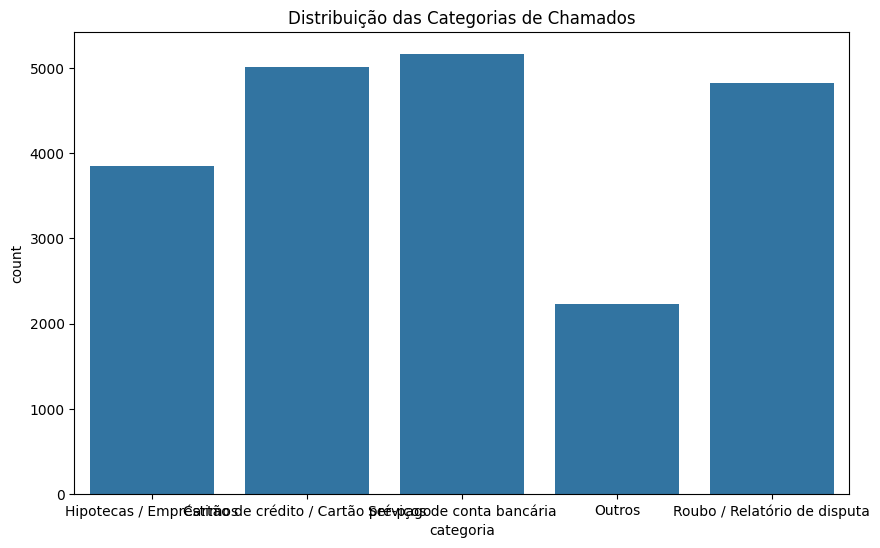

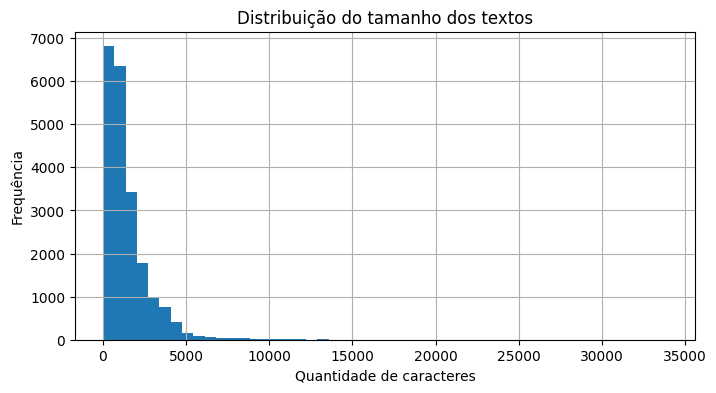

In [4]:
# O template fornecido pelo professor já inclui a URL pública
url = "https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv"
df = pd.read_csv(url, sep=';')

print("--- Visualização Inicial dos Dados ---")
print(df.head())
print("\n")

print("--- Informações do DataFrame (Tipos e Nulos) ---")
df.info()
print("\n")

# Verificar a distribuição das classes (o "y")
print("--- Distribuição das Categorias ---")
print(df['categoria'].value_counts())
print("\n")

# Verificar a distribuição das classes (o "y")
print("--- Distribuição das Categorias (%) ---")
print(df['categoria'].value_counts() / len(df) * 100)
print("\n")

# Visualizar a distribuição
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='categoria')
plt.title('Distribuição das Categorias de Chamados')
plt.show()

plt.figure(figsize=(8,4))
df['descricao_reclamacao'].str.len().hist(bins=50)
plt.title("Distribuição do tamanho dos textos")
plt.xlabel("Quantidade de caracteres")
plt.ylabel("Frequência")
plt.show()

O que vemos na distribuição é que, tirando a categoria "Outros", as outras seguem relativamente balanceadas.
Uma proporção perfeita seria todos com 20%, mas sendo a maior 24% e as duas menores possuem 18 e 10%, seguimos sem atuar na proporção.
A categoria "Outros" fica como um ponto de atenção.

##Pré-processamento e Limpeza dos Textos

Este bloco realiza o tratamento linguístico dos textos para preparar os dados de entrada ao modelo supervisionado.
As principais etapas aplicadas visam reduzir ruído, padronizar o vocabulário e extrair significado linguístico relevante.

####Etapas do processo:

* Conversão para minúsculas — uniformiza o texto, evitando distinção entre palavras como “Conta” e “conta”.
* Remoção de URLs, números e pontuações com expressões regulares (re.sub).
* Normalização de espaços — garante consistência no tokenização posterior.
* Tokenização e Lematização com SpaCy — transforma cada texto em uma lista de lemas (formas canônicas das palavras), reduzindo variações morfológicas.
* Remoção de stopwords — palavras funcionais sem valor semântico (ex.: “de”, “para”, “com”) são eliminadas.

O resultado é armazenado na nova coluna texto_processado, que contém a versão limpa e reduzida semanticamente de cada reclamação.
Esse passo é essencial para melhorar a qualidade da vetorização e o desempenho dos modelos de classificação.

In [5]:
# Baixar a lista de stopwords em português
nltk.download('stopwords')
stop_words_pt = stopwords.words('portuguese')

# Função de pré-processamento de texto
def tratar_texto(texto):
    if pd.isnull(texto):
        return ""
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+", " ", texto)           # remove URLs
    texto = re.sub(r"\d+", " ", texto)                      # remove números
    texto = re.sub(r"[^\w\s]", " ", texto)                  # remove pontuação
    texto = re.sub(r"\s+", " ", texto).strip()              # normaliza espaços
    doc = nlp(texto)
    tokens = [t.lemma_ for t in doc if not t.is_stop and not t.is_punct]
    return " ".join(tokens)

# Aplicar a função de limpeza na coluna 'descricao'
print("Iniciando pré-processamento dos textos...")
df['texto_processado'] = df['descricao_reclamacao'].apply(tratar_texto)
print("Pré-processamento concluído.")

print("\n--- Visualização após Pré-processamento ---")
print(df[['descricao_reclamacao', 'texto_processado']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Iniciando pré-processamento dos textos...
Pré-processamento concluído.

--- Visualização após Pré-processamento ---
                                descricao_reclamacao  \
0  Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1  Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2  O cartão Chase foi relatado em xx/xx/2019. No ...   
3  Em xx/xx/2018, enquanto tentava reservar um ti...   
4  Meu neto me dê cheque por {$ 1600,00} Eu depos...   

                                    texto_processado  
0  dia nome xxxx xxxx agradeço puder ajudar acaba...  
1  atualizei cartão xxxx xxxx xx xx informar agen...  
2  cartão chase relatar xx xx entanto pedido frau...  
3  xx xx tentar reservar ticket xxxx xxxx deparar...  
4  neto dê cheque depositar conta chase fundo lim...  


##Engenharia de Features (Vetorização)

* Definição de variáveis: X recebe o texto tratado (texto_processado) e y as classes (categoria).
* Split estratificado (75/25): separação em treino e teste com random_state=42 e stratify=y para preservar a proporção das classes no conjunto de teste.
* TF-IDF: criação do vocabulário no treino (fit_transform) e apenas transformação do teste (transform), evitando vazamento de informação.
* Saídas de diagnóstico: impressão das dimensões das matrizes esparsas de treino e teste para confirmar o número de amostras e de features geradas.

In [18]:
# 1. Definir X (features) e y (target)
X = df['texto_processado']
y = df['categoria']

# 2. Dividir em Treino e Teste
# Usaremos 75% para treino e 25% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.25,   # valor dado no enunciado
    random_state=42,  # Para resultados reproduzíveis
    stratify=y         # Importante para manter a proporção das classes
)

print(f"Tamanho do treino: {len(X_treino)} amostras")
print(f"Tamanho do teste: {len(X_teste)} amostras")
print("\n")

# 3. Vetorização com TF-IDF
# O TF-IDF (Term Frequency-Inverse Document Frequency) foi visto na Aula 3
print("Iniciando vetorização TF-IDF...")

# Instanciar o vetorizador
vetorizador_tfidf = TfidfVectorizer(ngram_range=(1, 2)) #análise de unigrama + bigrama

# 1. Aprender o vocabulário e transformar os dados de TREINO
X_treino_vet = vetorizador_tfidf.fit_transform(X_treino)

# 2. APENAS transformar os dados de TESTE (usando o vocabulário do treino)
X_teste_vet = vetorizador_tfidf.transform(X_teste)

print("Vetorização concluída.")
print(f"Formato da matriz de treino (amostras, features/palavras): {X_treino_vet.shape}")
print(f"Formato da matriz de teste (amostras, features/palavras): {X_teste_vet.shape}")

Tamanho do treino: 15804 amostras
Tamanho do teste: 5268 amostras


Iniciando vetorização TF-IDF...
Vetorização concluída.
Formato da matriz de treino (amostras, features/palavras): (15804, 588258)
Formato da matriz de teste (amostras, features/palavras): (5268, 588258)


##Modelagem e Treinamento

Neste bloco são treinados dois modelos clássicos de classificação de texto supervisionada para comparar desempenho:

Multinomial Naive Bayes (Baseline):
* Utiliza a suposição de independência entre features e é amplamente usado como ponto de partida em tarefas de NLP.
É leve, rápido e serve como referência de baseline para o projeto.
* Regressão Logística (Modelo mais robusto):
Capaz de capturar relações lineares entre as features TF-IDF e as classes.
Foi configurado com max_iter=1000 para garantir convergência estável, especialmente em datasets maiores.

Ao final, ambos os modelos são ajustados (fit) com os dados vetorizados de treino.
O objetivo é comparar o ganho de performance obtido ao evoluir do baseline probabilístico (Naive Bayes) para um classificador discriminativo (Logistic Regression).

In [19]:
# Vamos testar dois modelos clássicos para NLP:

# --- Modelo 1: Multinomial Naive Bayes (Baseline) ---
print("Treinando Modelo 1: Multinomial Naive Bayes...")
modelo_nb = MultinomialNB()
modelo_nb.fit(X_treino_vet, y_treino)
print("Modelo Naive Bayes treinado.")


# --- Modelo 2: Regressão Logística (Mais Robusto) ---
print("\nTreinando Modelo 2: Regressão Logística...")
modelo_lr = LogisticRegression(max_iter=1000) # max_iter para garantir convergência
modelo_lr.fit(X_treino_vet, y_treino)
print("Modelo Regressão Logística treinado.")

Treinando Modelo 1: Multinomial Naive Bayes...
Modelo Naive Bayes treinado.

Treinando Modelo 2: Regressão Logística...
Modelo Regressão Logística treinado.


##Avaliação dos Modelos (NB e Regressão Logística)

* Predição no conjunto de teste: gera y_pred_nb e y_pred_lr a partir das matrizes TF-IDF de teste.
* Métricas principais: imprime Acurácia e o classification_report (Precision, Recall e F1-Score por classe e médias macro/weighted).
* Requisito da disciplina: observar e reportar explicitamente o F1-Score (average='weighted') para verificar se supera 75%.
* Matrizes de confusão: plotam ConfusionMatrixDisplay para cada modelo, permitindo identificar quais classes mais se confundem e onde estão os erros sistemáticos.
* Uso esperado: comparar NB (baseline) vs. Regressão Logística (mais robusto) e escolher o modelo campeão com base no F1-weighted do conjunto de teste.

--- [AVALIAÇÃO] Multinomial Naive Bayes ---
Acurácia: 0.7449

Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.75      0.78      0.76      1252
            Hipotecas / Empréstimos       0.87      0.73      0.80       962
                             Outros       1.00      0.05      0.09       558
       Roubo / Relatório de disputa       0.74      0.83      0.78      1206
         Serviços de conta bancária       0.68      0.94      0.79      1290

                           accuracy                           0.74      5268
                          macro avg       0.81      0.67      0.65      5268
                       weighted avg       0.78      0.74      0.71      5268


Matriz de Confusão:


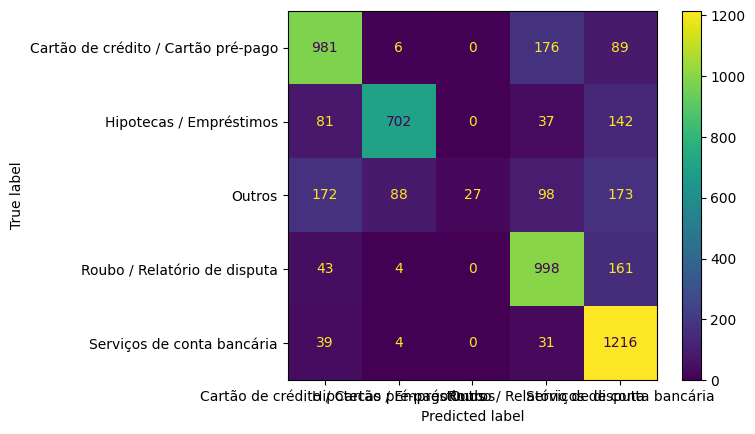



--- [AVALIAÇÃO] Regressão Logística ---
Acurácia: 0.9058

Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.91      0.92      0.92      1252
            Hipotecas / Empréstimos       0.92      0.91      0.92       962
                             Outros       0.91      0.82      0.86       558
       Roubo / Relatório de disputa       0.89      0.89      0.89      1206
         Serviços de conta bancária       0.90      0.94      0.92      1290

                           accuracy                           0.91      5268
                          macro avg       0.91      0.90      0.90      5268
                       weighted avg       0.91      0.91      0.91      5268


Matriz de Confusão:


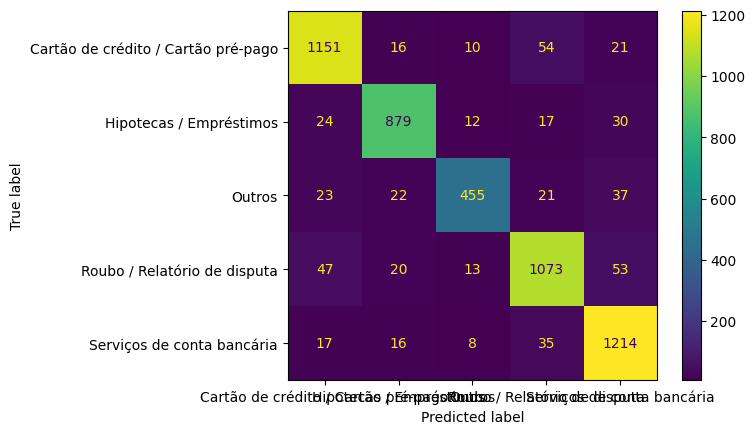

In [20]:
# --- Avaliação do Modelo 1: Multinomial Naive Bayes ---
print("--- [AVALIAÇÃO] Multinomial Naive Bayes ---")
y_pred_nb = modelo_nb.predict(X_teste_vet)

# Acurácia
acc_baseline = accuracy_score(y_teste, y_pred_nb) # ✅ baseline definido aqui
print(f"Acurácia: {acc_baseline:.4f}")

# Relatório de Classificação (Precision, Recall, F1-Score)
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred_nb))

# Matriz de Confusão
print("\nMatriz de Confusão:")
cm_nb = confusion_matrix(y_teste, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=modelo_nb.classes_)
disp_nb.plot()
plt.show()


# --- Avaliação do Modelo 2: Regressão Logística ---
print("\n\n--- [AVALIAÇÃO] Regressão Logística ---")
y_pred_lr = modelo_lr.predict(X_teste_vet)

# Acurácia
acc_lr = accuracy_score(y_teste, y_pred_lr)
print(f"Acurácia: {acc_lr:.4f}")

# Relatório de Classificação (Precision, Recall, F1-Score)
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred_lr))

# Matriz de Confusão
print("\nMatriz de Confusão:")
cm_lr = confusion_matrix(y_teste, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=modelo_lr.classes_)
disp_lr.plot()
plt.show()

##Comparação de Modelos

Este bloco consolida e compara o desempenho dos classificadores treinados.
Ele cria uma estrutura resiliente, capaz de lidar com a ausência de variáveis (evitando erros como NameError), e organiza os resultados de forma visual e ordenada.

Etapas principais:
* Validação das variáveis: garante que acc_baseline e acc_lr existam, atribuindo valores padrão se necessário.
* Criação dinâmica da tabela de resultados: armazena o nome do modelo e sua acurácia em um DataFrame.
* Ordenação decrescente: destaca o modelo de melhor desempenho no topo.
* Visualização gráfica: gera um gráfico de barras comparando a acurácia entre modelos.

Esse bloco fecha a análise experimental, facilitando a interpretação dos resultados e escolha do modelo campeão para o pipeline final.


📊 Comparação de Desempenho entre Modelos:
                                 Modelo  Acurácia
0                   Regressão logística  0.905847
1  Baseline (TF-IDF Unigrams + bigrams)  0.744875


/tmp/ipython-input-1164013934.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados, x='Acurácia', y='Modelo', palette='Blues_d')


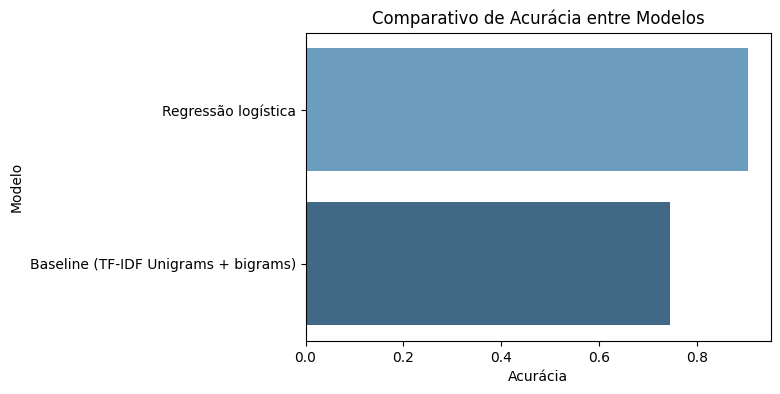

In [24]:
# Garante que a variável acc_baseline exista
try:
    acc_baseline
except NameError:
    print("⚠️ Variável acc_baseline não encontrada. Definindo valor padrão 0.")
    acc_baseline = 0

# Garante que a variável acc_lr exista
try:
    acc_lr
except NameError:
    print("⚠️ Variável acc_base não encontrada. Definindo baseline como Regressão Logística (unigramas).")
    acc_lr = accuracy_score(y_teste, y_pred_lr)

# Monta tabela de comparação dinâmica
resultados = pd.DataFrame([
    {'Modelo': 'Baseline (TF-IDF Unigrams + bigrams)', 'Acurácia': acc_baseline},
    {'Modelo': 'Regressão logística', 'Acurácia': acc_lr}
])

# Ordena por acurácia
resultados = resultados.sort_values(by='Acurácia', ascending=False).reset_index(drop=True)

# Exibe resultado
print("\n📊 Comparação de Desempenho entre Modelos:")
print(resultados)

# Visualização opcional
plt.figure(figsize=(6,4))
sns.barplot(data=resultados, x='Acurácia', y='Modelo', palette='Blues_d')
plt.title('Comparativo de Acurácia entre Modelos')
plt.xlabel('Acurácia')
plt.ylabel('Modelo')
plt.show()


##Representação Semântica com Word2Vec

Neste bloco aplicamos o Word2Vec, técnica de embeddings que representa cada palavra como um vetor contínuo em um espaço semântico.
Diferente do TF-IDF, que apenas mede a frequência de termos, o Word2Vec captura relações de significado e contexto entre palavras (ex.: “erro” e “problema” ficam próximos no espaço vetorial).

####Etapas principais:
* Tokenização dos textos em listas de palavras.
* Treinamento do modelo Word2Vec com o corpus de treino.
* Conversão de cada texto em vetor médio das palavras.
* Classificação supervisionada com RandomForestClassifier.

Essa abordagem adiciona compreensão semântica ao pipeline e pode melhorar o F1 Score para categorias com vocabulário semelhante.


In [25]:
# Tokenização simples: transforma textos processados em listas de palavras
tokens_treino = [text.split() for text in X_treino]
tokens_teste = [text.split() for text in X_teste]

# Treina o modelo Word2Vec
print("Treinando modelo Word2Vec...")
w2v_model = Word2Vec(
    sentences=tokens_treino,
    vector_size=100,   # tamanho do vetor de embedding
    window=5,          # contexto de palavras vizinhas
    min_count=2,       # ignora palavras raras
    workers=4,
    sg=1               # skip-gram (melhor para capturar semântica)
)
print("Treinamento concluído.")

# Função para gerar vetor médio por texto
def vetor_medio(texto, modelo):
    palavras = [w for w in texto.split() if w in modelo.wv.key_to_index]
    if len(palavras) == 0:
        return np.zeros(modelo.vector_size)
    return np.mean([modelo.wv[w] for w in palavras], axis=0)

# Criação dos vetores médios
X_treino_w2v = np.array([vetor_medio(texto, w2v_model) for texto in X_treino])
X_teste_w2v = np.array([vetor_medio(texto, w2v_model) for texto in X_teste])

# Classificador supervisionado com Random Forest
print("Treinando classificador com embeddings Word2Vec...")
modelo_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_w2v.fit(X_treino_w2v, y_treino)
print("Modelo treinado.")

# Avaliação
y_pred_w2v = modelo_w2v.predict(X_teste_w2v)
acc_w2v = accuracy_score(y_teste, y_pred_w2v)
print(f"Acurácia (Word2Vec): {acc_w2v:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred_w2v))

Treinando modelo Word2Vec...
Treinamento concluído.
Treinando classificador com embeddings Word2Vec...
Modelo treinado.
Acurácia (Word2Vec): 0.8197

Relatório de Classificação:
                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.82      0.84      0.83      1252
            Hipotecas / Empréstimos       0.82      0.87      0.85       962
                             Outros       0.79      0.59      0.68       558
       Roubo / Relatório de disputa       0.80      0.81      0.81      1206
         Serviços de conta bancária       0.84      0.87      0.85      1290

                           accuracy                           0.82      5268
                          macro avg       0.82      0.80      0.80      5268
                       weighted avg       0.82      0.82      0.82      5268



##Inclusão do Modelo Word2Vec na Comparação Final

Para garantir uma visão consolidada do desempenho dos modelos, o resultado do Word2Vec é integrado ao DataFrame de comparação,
permitindo observar a evolução da acurácia e facilitar a escolha do modelo campeão.


📊 Comparação Final entre Modelos:
                                 Modelo  Acurácia
0                   Regressão logística  0.905847
1               Word2Vec + RandomForest  0.819666
2  Baseline (TF-IDF Unigrams + bigrams)  0.744875


/tmp/ipython-input-4255786279.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados, x='Acurácia', y='Modelo', palette='Purples_r')


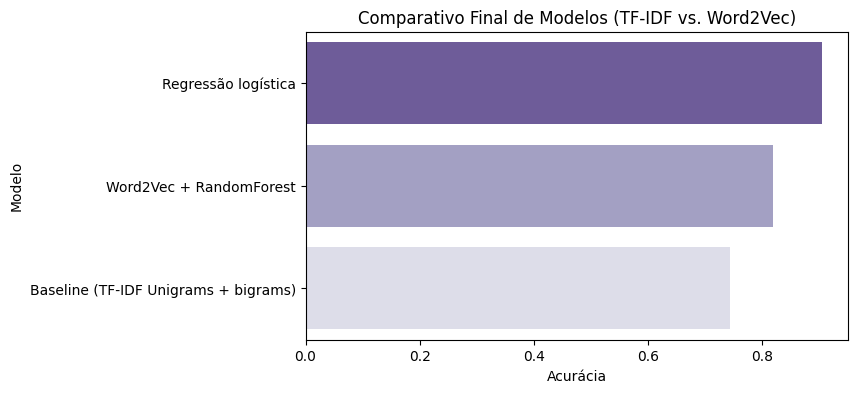

In [26]:
# Cria um novo DataFrame com o resultado do Word2Vec
novo_resultado = pd.DataFrame([{
    'Modelo': 'Word2Vec + RandomForest',
    'Acurácia': acc_w2v
}])

# Concatena com o DataFrame existente de resultados
resultados = pd.concat([resultados, novo_resultado], ignore_index=True)

# Atualiza visualização final
resultados = resultados.sort_values(by='Acurácia', ascending=False).reset_index(drop=True)
print("\n📊 Comparação Final entre Modelos:")
print(resultados)

plt.figure(figsize=(7,4))
sns.barplot(data=resultados, x='Acurácia', y='Modelo', palette='Purples_r')
plt.title('Comparativo Final de Modelos (TF-IDF vs. Word2Vec)')
plt.xlabel('Acurácia')
plt.ylabel('Modelo')
plt.show()

# 7. Conclusão e Próximos Passos

**Análise dos Resultados:**
* Como é possível ver na imagem acima, o modelo Regressão Logística com TF-IDF (unigrama + bigrama) teve a maior acurácia (90.58%) e também o melhor F1-Score ponderado (~0,91).
Isso indica que ele é o mais equilibrado e confiável para classificação de textos no conjunto analisado, sendo o modelo mais indicado para uso produtivo.

* A sua matriz de confusão apenas reforça a sua escolha, junto com a análise de recall e f1 para cada categoria, vemos que todos os F1-Scores estão acima de 0.86, com um recall de 0.90 temos um modelo forte e equilibrado.

* Word2Vec + RandomForest também encontrou bons resultados com uma acurácia alta, mas a categoria "Outros" teve um desempenho abaixo do esperado, com um f1-score de 0.68, um ponto de atenção.

* O modelo Naive Bayes, nossa baseline, ficou próximo da acurácia mínima exigida, chegando a 74.5%. Aqui, a classe "Outros" foi um problema especial, chegando uma precisão de 1 e recall de 0.05, F1 de quase zero (0.09). Isso é como se o modelo nunca classificasse como "Outros" por ter dúvida.

* A classe "Outros" foi a que percebemos ter a menor fatia de dados (10.5%), foi levantado como um ponto de atenção e apenas um dos modelos conseguiu trabalhar com uma categoria desbalanceada.

* Se olharmos a matriz de confusão para a regressão linear, mesmo com bons resultados tivemos algumas categorias que se confundem mais uma com as outras, por exemplo "Roubo / Relatório de disputa" 'perde' um pouco mais para "Cartão de crédito / Cartão pré-pago" do que para outras classes. Uma hipótese é que a palavra "cartão" possa estar influenciando se um chamado é algo como "Perdi meu cartão ..." ou "Roubaram meu cartão ...". "Serviços de conta bancária" tem uma perda distribuída de forma mais igualitária, o que pode até ser de se esperar, sabendo que nessa categoria devemos ter uma gama de palavras mais ampla.

**Dificuldades:**
* A classe "Outros" ser desbalanceada é um grande desafio, que acabou por ser contornado pelo uso do modelo de regressão linear. Porém, fica como um ponto de atenção para os outros modelos.

* Relação custo-benefício do uso ou não de unigramas+bigramas ou somente unigramas, já que nos testes os resultados ficaram próximos. Esse cálculo do custo de processamento é uma dificuldade real que vamos precisar enfrentar na implementação de um modelo.

**Próximos Passos:**
* O estado da arte seria aplicar a técnica de **Fine-Tuning (Ajuste Fino)** em um modelo **Transformer (como o BERT)**, que entende o contexto de forma bidirecional (visto na Aula 5).
* Outra alternativa seria usar **IA Generativa (LLMs)** com **Engenharia de Prompt (Zero-Shot ou Few-Shot)** para classificar os textos, como visto na Aula 6.
* Interessante ver que mesmo com a perda de informação da vetorização, o resultado foi melhor do que o Word2Vec, que tem uma captura semântica melhor.
* Fazer testes com outros tratamentos na base de dados, ou também com a vetorização em trigramas e outras combinações.